In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
import torch.nn as nn
import torch.nn.functional as f
import torch.optim as optim
from matplotlib import pyplot as plt

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
transform = transforms.Compose([
    transforms.Resize((200, 200)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [7]:
dataset = torchvision.datasets.ImageFolder(root='../generatingSpectograms/instrument_dataset', transform=transform)

In [8]:
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [9]:
class CNNModel(nn.Module):
    def __init__(self, num_classes=len(dataset.classes)):
        super(CNNModel, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3)
        self.bn1 = nn.BatchNorm2d(8)

        self.conv2 = nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3)
        self.bn2 = nn.BatchNorm2d(16)

        self.conv3 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3)
        self.bn3 = nn.BatchNorm2d(32)

        self.conv4 = nn.Conv2d(in_channels=32, out_channels=128, kernel_size=3)
        self.bn4 = nn.BatchNorm2d(128)

        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout = nn.Dropout(0.5)

        self.fc = nn.Linear(12800, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = f.relu(x)
        x = self.maxpool(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = f.relu(x)
        x = self.maxpool(x)

        x = self.conv3(x)
        x = self.bn3(x)
        x = f.relu(x)
        x = self.maxpool(x)

        x = self.conv4(x)
        x = self.bn4(x)
        x = f.relu(x)
        x = self.maxpool(x)

        x = torch.flatten(x, 1)
        x = self.dropout(x)
        x = self.fc(x)

        return x

In [10]:
model = CNNModel()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

loss_arr = []

epochs = 3
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss/len(train_loader)}")
    loss_arr.append(running_loss/len(train_loader))

Epoch 1/3, Loss: 0.808835022081621
Epoch 2/3, Loss: 0.004306078162820389
Epoch 3/3, Loss: 0.0014185539349758378


In [11]:
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in val_loader:
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Validation Accuracy: {correct / total:.2f}')


Validation Accuracy: 1.00


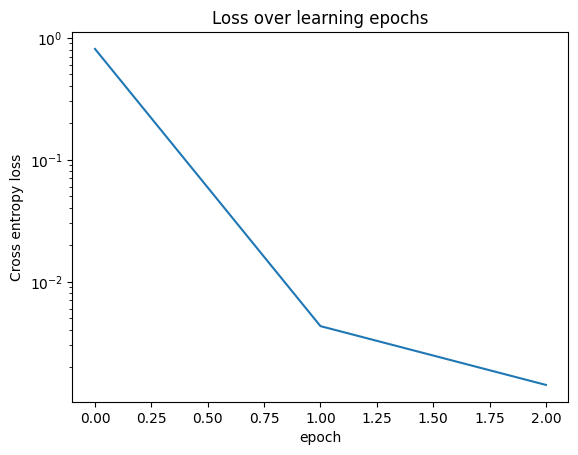

In [12]:
plt.figure()
plt.semilogy(loss_arr)
plt.xlabel("epoch")
plt.ylabel("Cross entropy loss")
plt.title("Loss over learning epochs")
plt.show()

# Concept propagation

In [24]:
from PIL import Image
from crp.helper import get_layer_names
from zennit.composites import EpsilonPlusFlat
from zennit.canonizers import SequentialMergeBatchNorm
from crp.attribution import CondAttribution
from crp.image import imgify
from crp.concepts import ChannelConcept


In [25]:
cc = ChannelConcept()

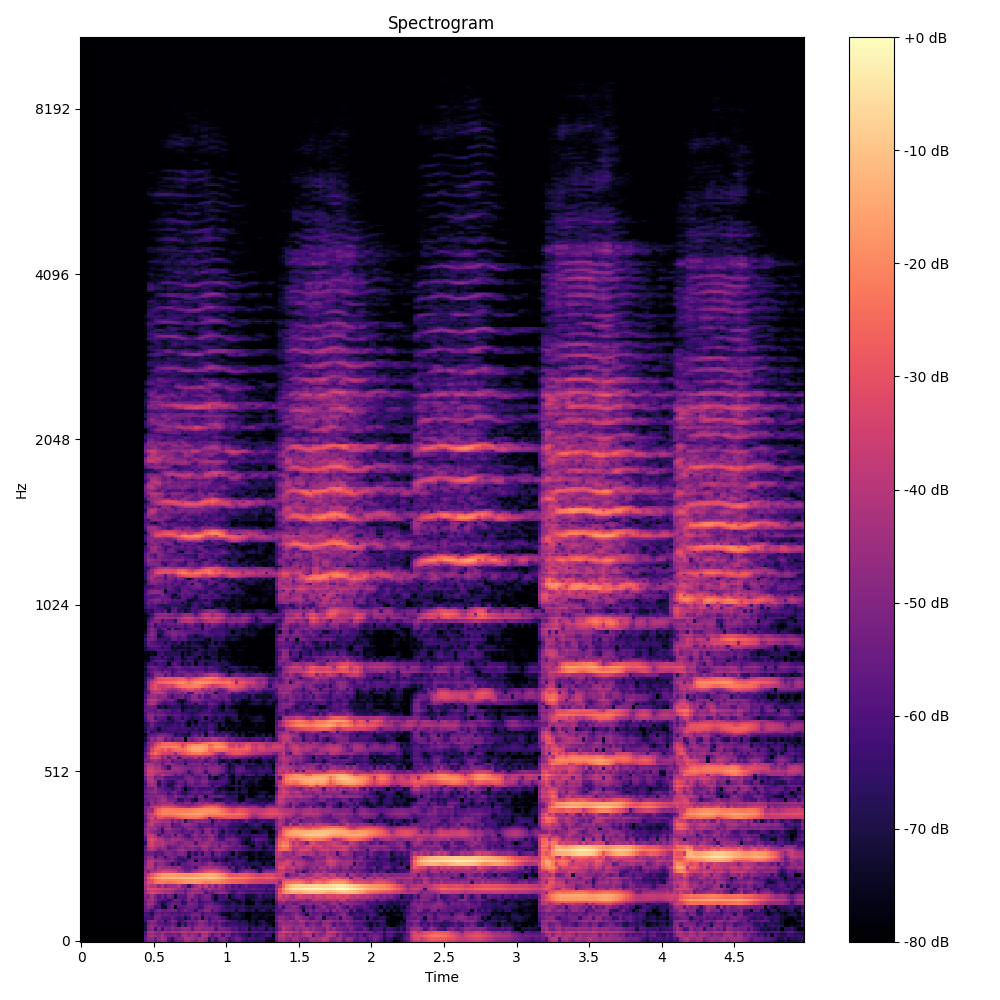

In [55]:
image = Image.open("./violin_40.png").convert('RGB')
sample = transform(image).unsqueeze(0).to(device)

image

In [49]:
composite = EpsilonPlusFlat([SequentialMergeBatchNorm()])
attribution = CondAttribution(model, no_param_grad=True)

In [58]:
# compute heatmap
conditions = [{"y": 0}]

# zennit requires gradients
sample.requires_grad = True
attr = attribution(sample, conditions, composite, mask_map=cc.mask)

# or use a dictionary for mask_map
layer_names = get_layer_names(model, [torch.nn.Conv2d, torch.nn.Linear])
mask_map = {name: cc.mask for name in layer_names}

attr = attribution(sample, conditions, composite, mask_map=mask_map)

True


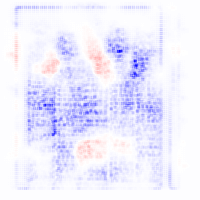

In [59]:
print(torch.equal(attr[0], attr.heatmap))

imgify(attr.heatmap, symmetric=True)